In [5]:
from os import path

# Third-party
from astropy.constants import c
from astropy.table import Table, Column
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('apw-notebook')
%matplotlib inline
from scipy.special import wofz
from scipy.signal import argrelmax

# Project
from comoving_rv.longslit.fitting.gaussian import fit_spec_line_GP, gp_to_fit_pars, get_init_guess
from comoving_rv.longslit.models import gaussian_polynomial, binned_gaussian_polynomial
from comoving_rv.longslit import GlobImageFileCollection

## Find exposures that are long enough, find centroid of O lines at 5577, 6300, 6364 and see how they vary with airmass

In [6]:
def fit_sky_region(x, flux, ivar, center, width, plot=False):
    _idx = np.abs(x - center) < width # x pixels on either side of center
    
    x = x[_idx]
    flux = flux[_idx]
    ivar = ivar[_idx]
    
    sort_ = x.argsort()
    wave_data = x[sort_]
    flux_data = flux[sort_]
    err_data = 1/np.sqrt(ivar[sort_])
    
    # better initial guess for GP parameters
    mask = np.abs(wave_data - center) > 2.
    y_MAD = np.median(np.abs(flux[mask] - np.median(flux[mask])))
    log_sigma0 = np.log(5*y_MAD)
    
    # find largest line closest to center
    max_idx, = argrelmax(flux_data)
    max_waves = wave_data[max_idx]
    max_idx = max_idx[np.argmin(np.abs(max_waves - center))]
    gp = fit_spec_line_GP(wave_data, flux_data, ivar, absorp_emiss=1.,
                          std0=1., x0=wave_data[max_idx],
                          log_sigma0=log_sigma0, log_rho0=np.log(10.))

    wave_grid = np.linspace(wave_data.min(), wave_data.max(), 256)
    mu, var = gp.predict(flux_data, wave_grid, return_var=True)
    std = np.sqrt(var)
    
    fit_pars = gp_to_fit_pars(gp, 1.)
    
    if plot:
        # ------------------------------------------------------------------------
        # Plot the maximum likelihood model
        fig,axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

        # data
        for ax in axes:
            ax.plot(wave_data, flux_data, drawstyle='steps-mid', 
                    marker='', color='#777777', zorder=-11)
            ax.errorbar(wave_data, flux_data, err_data,
                        marker='', ls='none', ecolor='#666666', zorder=-10)

        # mean model
        axes[0].plot(wave_grid, gaussian_polynomial(wave_grid, **fit_pars),
                     marker='', alpha=0.5, zorder=100, color='r')
        axes[1].plot(wave_grid, binned_gaussian_polynomial(wave_grid, **fit_pars),
                     marker='', alpha=0.5, zorder=101, drawstyle='steps-mid', color='g')

        # full GP model
        gp_color = "#ff7f0e"
        axes[2].plot(wave_grid, mu, color=gp_color, marker='')
        axes[2].fill_between(wave_grid, mu+std, mu-std, color=gp_color,
                             alpha=0.3, edgecolor="none")

        for ax in axes: ax.set_xlabel(r'wavelength [$\AA$]')
        axes[0].set_ylabel('flux')

        fig.tight_layout()
    
    # some validation
    max_ = fit_pars['amp'] / np.sqrt(2*np.pi*fit_pars['std']**2) 
    SNR = max_ / np.median(err_data)
    
    if ((abs(fit_pars['x0']-center) > 4) or (fit_pars['amp'] < 10) or 
            (fit_pars['std'] > 4) or (SNR < 3)):
        # FAILED
        return None
    
    return fit_pars

In [7]:
def sky_line_centroids(tbl, line_waves=[5577., 6300., 6364.], window_width=21, plot=False):    
    with np.errstate(invalid='ignore'):
        clean = np.isfinite(tbl['wavelength']) & (tbl['wavelength'] > 0)
    
    line_idx = [np.argmin(np.abs(tbl['wavelength'][clean] - w)) 
                for w in [5577., 6300., 6364.]]
    line_pixels = tbl['pix'][clean][line_idx]
    
    pixl = tbl['pix']
    flux = tbl['background_flux']
    ivar = tbl['background_ivar']
    
    fit_centroids = []
    for pix_ctr in line_pixels:
        pars = fit_sky_region(pixl, flux, ivar, 
                              pix_ctr, window_width, plot=plot)

        if pars is None:
            fit_centroids.append(np.nan)
            if plot: plt.title('fucked', fontsize=28)
            
        else:
            fit_centroids.append(pars['x0'])
    
    return np.array(fit_centroids)

HIP28066 10.0


array([         nan,  815.8771311,          nan])

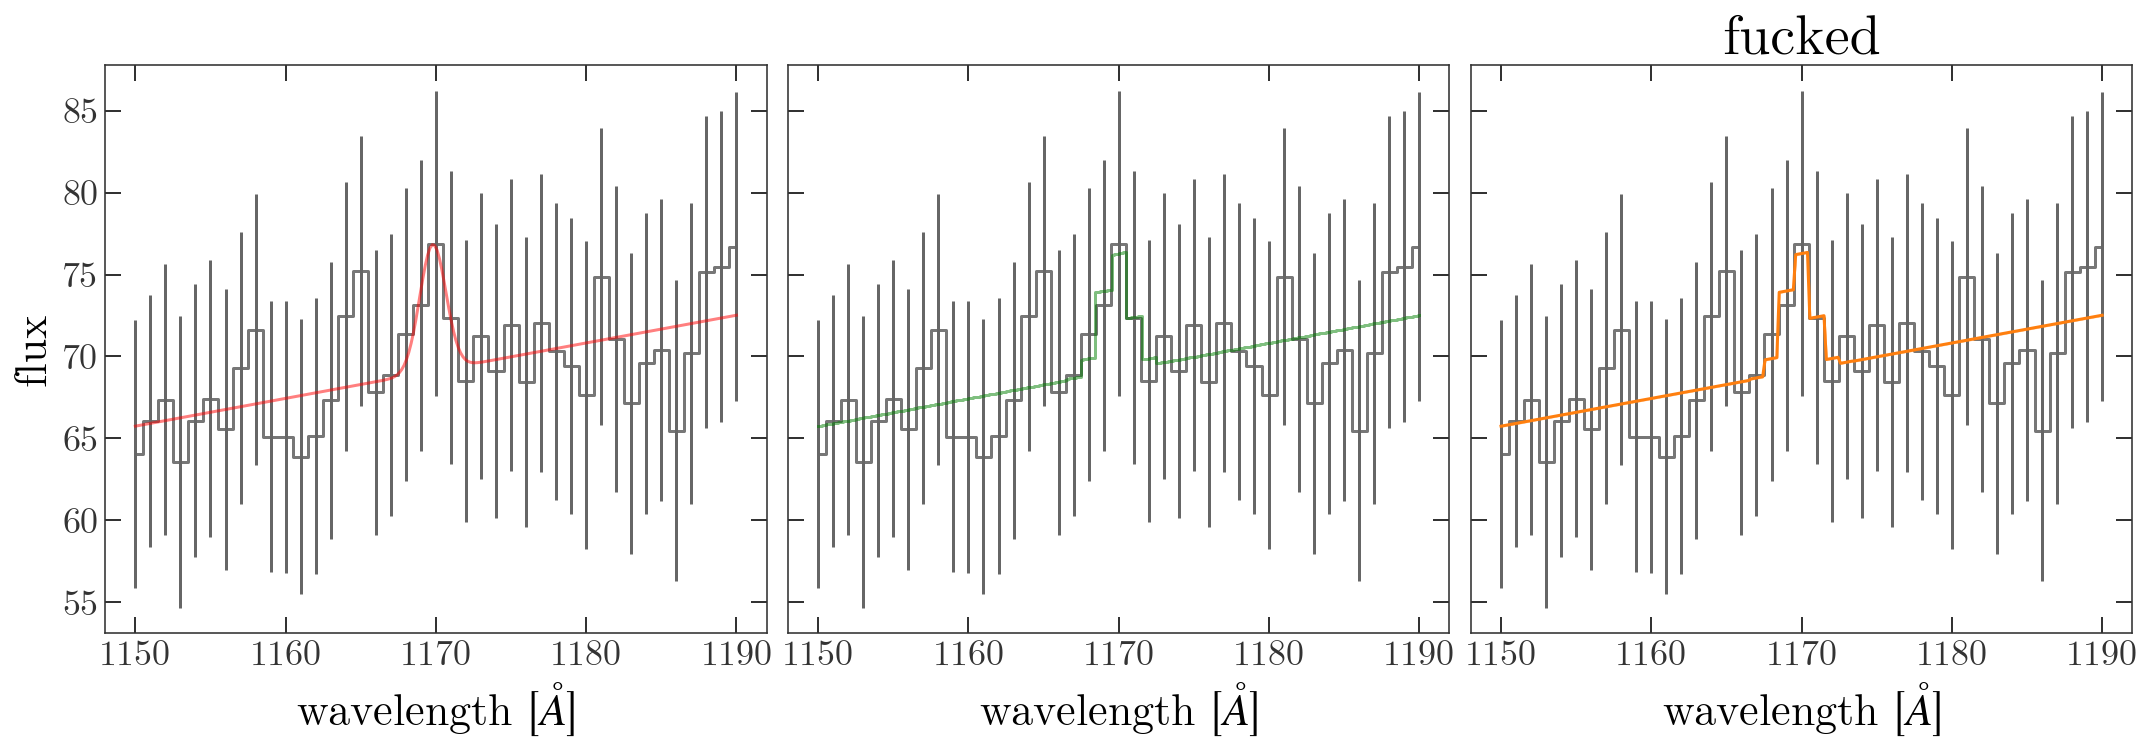

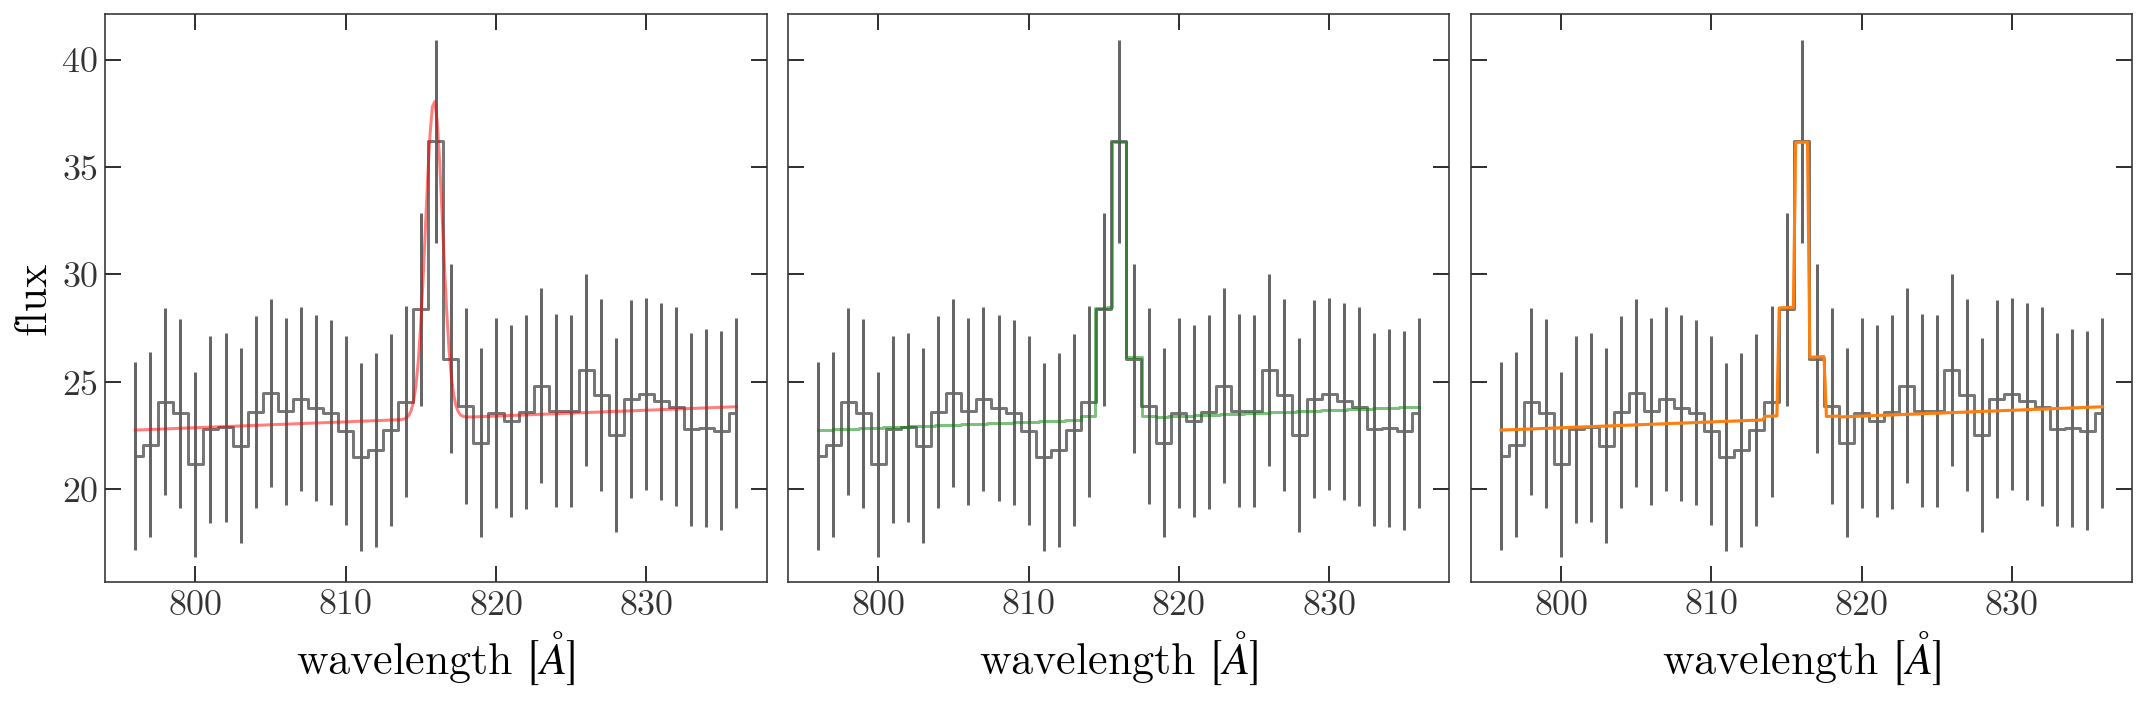

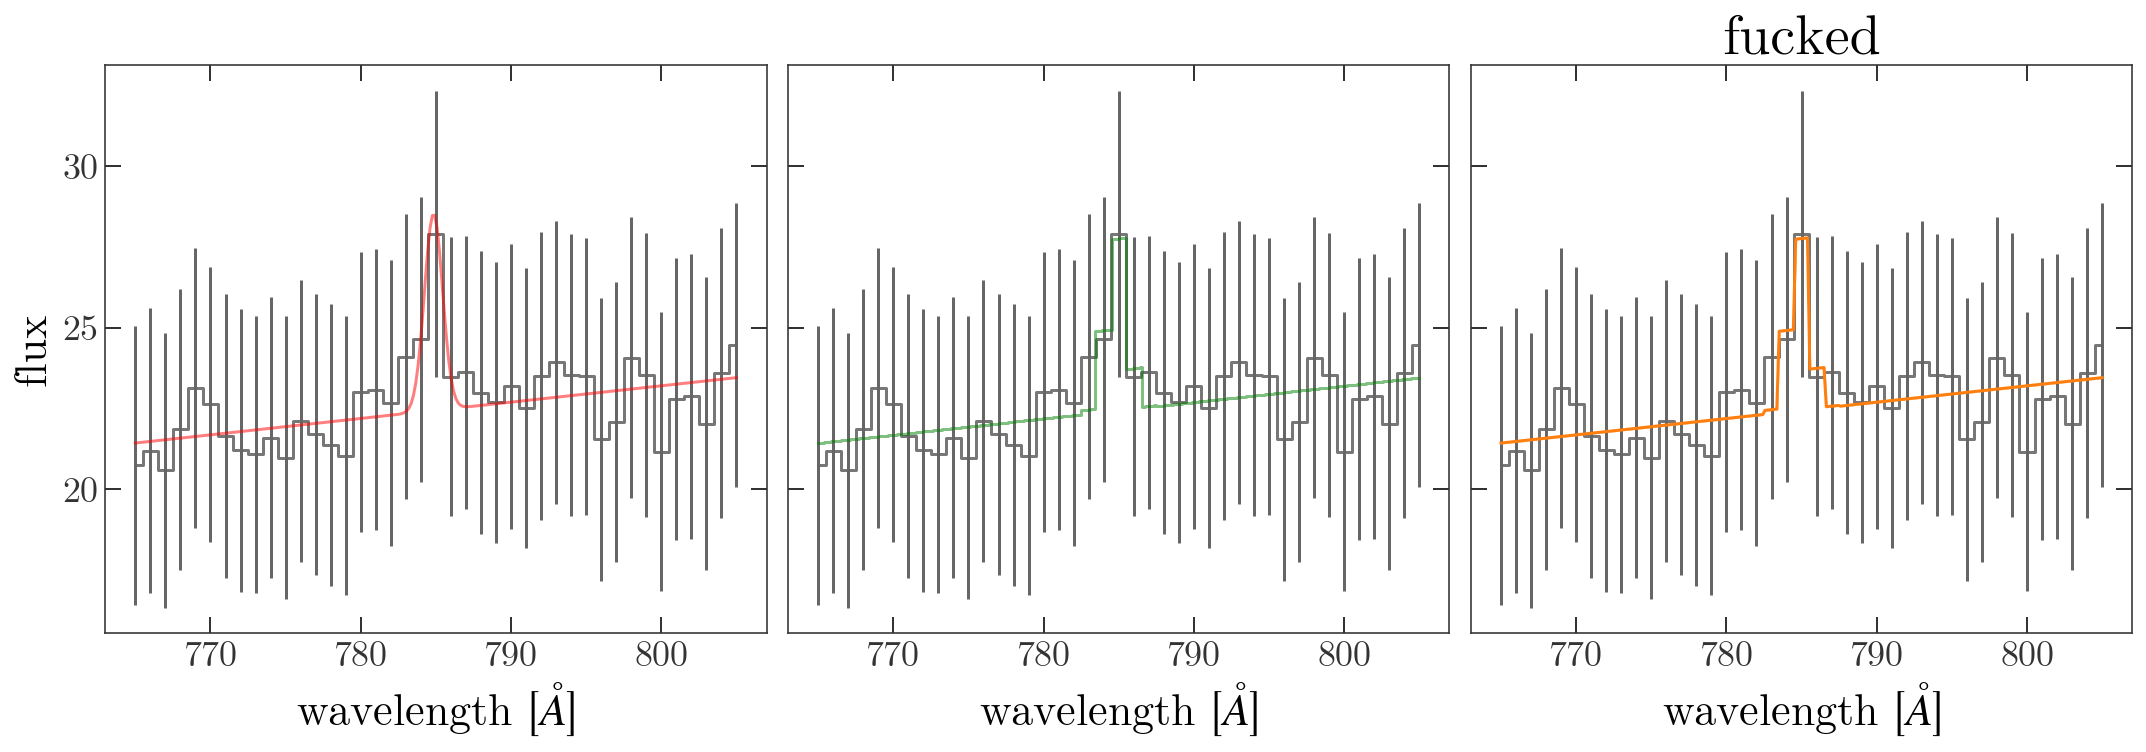

In [8]:
# testing
filename = '/Volumes/ProjectData/gaia-comoving-followup/data/processed/mdm-spring-2017/n4/1d_n4.0026.fit'
tbl = fits.getdata(filename, 1)
hdr = fits.getheader(filename, 0)
print(hdr['OBJECT'], hdr['EXPTIME'])
sky_line_centroids(tbl, plot=True)

In [84]:
stat_tbl = Table()
stat_tbl.add_column(Column(name='object', dtype='|U64'))
stat_tbl.add_column(Column(name='filename', dtype='|U128'))
stat_tbl.add_column(Column(name='night', dtype='i4'))
stat_tbl.add_column(Column(name='secz'))
stat_tbl.add_column(Column(name='line_centers', shape=(3,)))

In [90]:
# for n in range(1, 5+1):
for n in [4]:
    base_path = '/Volumes/ProjectData/gaia-comoving-followup/data/processed/mdm-spring-2017/n' + str(n)
    ifc = GlobImageFileCollection(location=base_path, glob_include='1d*')

    print(n)
    for filename in ifc.files_filtered(IMAGETYP='OBJECT'):
        file_path = path.abspath(path.join(ifc.location, filename))
        hdr = fits.getheader(file_path)
        
        tbl = fits.getdata(file_path, 1)
        line_centers = sky_line_centroids(tbl)
        stat_tbl.add_row([hdr['OBJECT'], file_path, n, hdr['AIRMASS'], line_centers])

4


/Users/adrian/anaconda/envs/comoving-rv/lib/python3.6/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in sqrt
/Users/adrian/projects/gaia-comoving-followup/comoving_rv/longslit/fitting/gaussian.py:238: RuntimeWarning: invalid value encountered in log
  p0['ln_amp'] = np.log(absorp_emiss * p0.pop('amp'))


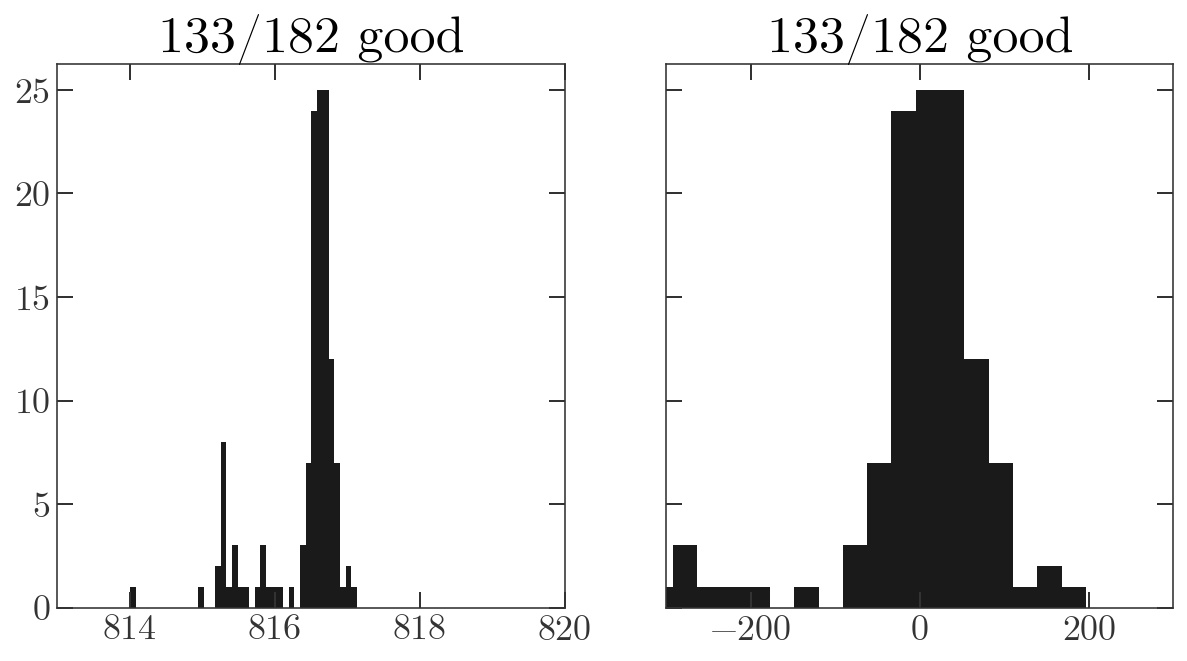

In [94]:
lcs = stat_tbl['line_centers'][:,1]

fig,axes = plt.subplots(1,2,figsize=(10,5),sharey=True)

axes[0].hist(lcs[np.isfinite(lcs)], bins='auto')
axes[0].set_xlim(813, 820)
axes[0].set_title('{}/{} good'.format(np.isfinite(lcs).sum(), len(lcs)))

axes[1].hist((lcs[np.isfinite(lcs)]-np.nanmedian(lcs))/np.nanmedian(lcs) * 3E5, 
             bins='auto')
axes[1].set_xlim(-300, 300)
axes[1].set_title('{}/{} good'.format(np.isfinite(lcs).sum(), len(lcs)))

/Users/adrian/anaconda/envs/comoving-rv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:986: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


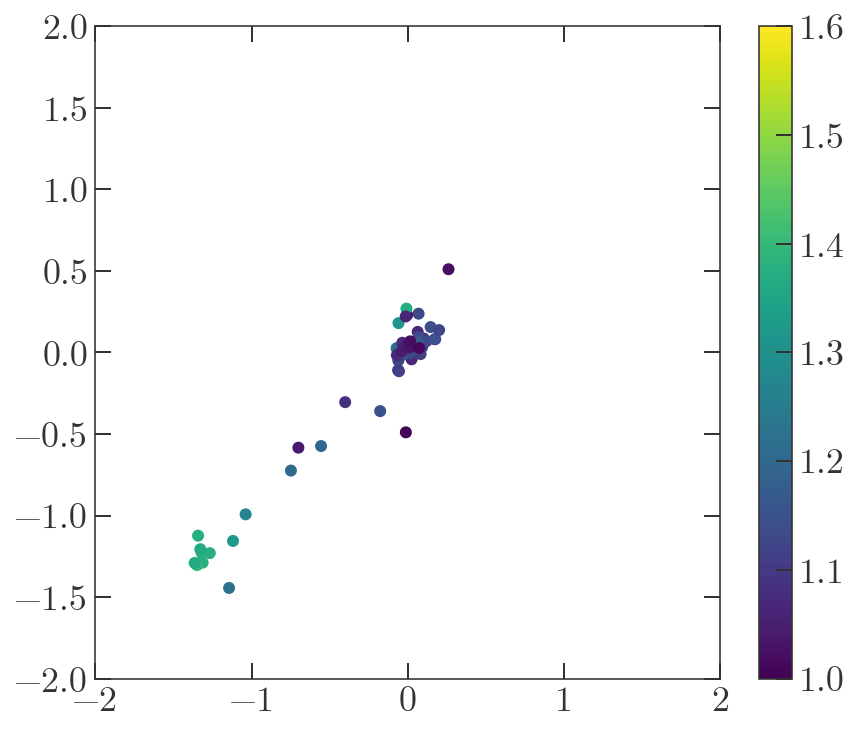

In [95]:
l = 1
r = 2

plt.figure(figsize=(7,6))
for n in range(1, 5+1):
    night_tbl = stat_tbl[stat_tbl['night'] == n]
    
    plt.scatter(night_tbl['line_centers'][:,l]-np.nanmedian(night_tbl['line_centers'][:,l]), 
                night_tbl['line_centers'][:,r]-np.nanmedian(night_tbl['line_centers'][:,r]), 
                c=night_tbl['secz'], vmin=1., vmax=1.6)

plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.colorbar()

## Now try fitting some absorption lines

In [25]:
from comoving_rv.longslit.fitting.voigt import fit_spec_line_GP, gp_to_fit_pars, get_init_guess
from comoving_rv.longslit.models import voigt_polynomial, binned_voigt_polynomial

In [23]:
def fit_source_region(x, flux, ivar, center, width, absorp_emiss=-1., plot=False):
    _idx = np.abs(x - center) < width
    
    x = x[_idx]
    flux = flux[_idx]
    ivar = ivar[_idx]
    
    sort_ = x.argsort()
    wave_data = x[sort_]
    flux_data = flux[sort_]
    err_data = 1/np.sqrt(ivar[sort_])
    
    # better initial guess for GP parameters
    mask = np.abs(wave_data - center) > 5.
    y_MAD = np.median(np.abs(flux[mask] - np.median(flux[mask])))
    log_sigma0 = np.log(5*y_MAD)
       
    gp = fit_spec_line_GP(wave_data, flux_data, ivar, absorp_emiss=absorp_emiss,
                          std_G0=2., hwhm_L0=0.1, log_sigma0=log_sigma0, log_rho0=np.log(10.))

    wave_grid = np.linspace(wave_data.min(), wave_data.max(), 256)
    mu, var = gp.predict(flux_data, wave_grid, return_var=True)
    std = np.sqrt(var)
    
    fit_pars = gp_to_fit_pars(gp, absorp_emiss)
    
    if plot:
        # ------------------------------------------------------------------------
        # Plot the maximum likelihood model
        fig,axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

        # data
        for ax in axes:
            ax.plot(wave_data, flux_data, drawstyle='steps-mid', 
                    marker='', color='#777777', zorder=-11)
            ax.errorbar(wave_data, flux_data, err_data,
                        marker='', ls='none', ecolor='#666666', zorder=-10)

        # mean model
        axes[0].plot(wave_grid, voigt_polynomial(wave_grid, **fit_pars),
                     marker='', alpha=0.5, zorder=100, color='r')
        axes[1].plot(wave_data, binned_voigt_polynomial(wave_data, **fit_pars),
                     marker='', alpha=0.5, zorder=101, drawstyle='steps-mid', color='g')

        # full GP model
        gp_color = "#ff7f0e"
        axes[2].plot(wave_grid, mu, color=gp_color, marker='')
        axes[2].fill_between(wave_grid, mu+std, mu-std, color=gp_color,
                             alpha=0.3, edgecolor="none")

        for ax in axes: ax.set_xlabel(r'wavelength [$\AA$]')
        axes[0].set_ylabel('flux')

        fig.tight_layout()
    
    print(fit_pars)
    
    if ((abs(fit_pars['x0']-center) > 8) or (fit_pars['amp'] < 10) or 
            (fit_pars['std'] > 4)):
        # FAILED
        return None
    
    return fit_pars

HIP23941 2.0


/Users/adrian/anaconda/envs/comoving-rv/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


OrderedDict([('amp', -248828.57851512742), ('x0', 6565.3058548747495), ('std_G', 0.0), ('hwhm_L', 2.0998987875002477), ('bg_coef', [86882.003217714824, -93.027909347114331])])


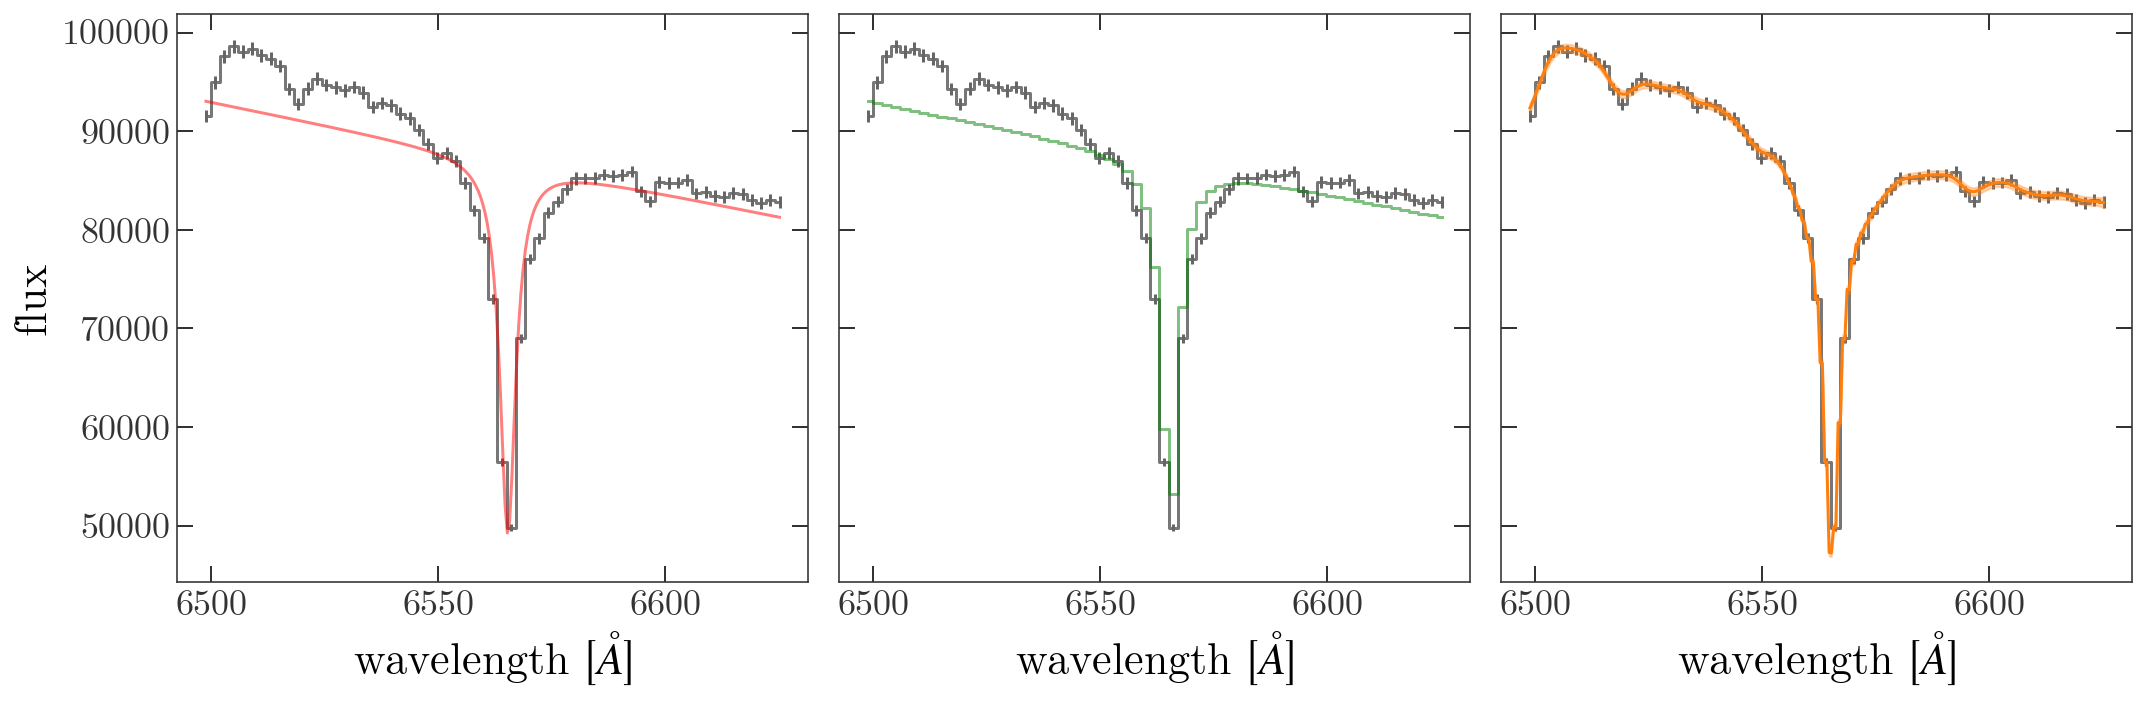

In [24]:
# testing
filename = '/Volumes/ProjectData/gaia-comoving-followup/data/processed/mdm-spring-2017/n4/1d_n4.0031.fit'
tbl = fits.getdata(filename, 1)
hdr = fits.getheader(filename, 0)
print(hdr['OBJECT'], hdr['EXPTIME'])

x = tbl['wavelength']
flux = tbl['source_flux']
ivar = tbl['source_ivar']
fit_source_region(x, flux, ivar, center=6562.8, width=64, absorp_emiss=-1., plot=True)